# Face Recognition CNN Model Training

This notebook trains a CNN model for face recognition using a small dataset with data augmentation.

**Dataset Structure:**
- Dataset/avoy/ - 36 images
- Dataset/navin/ - 25 images
- Dataset/rakin/ - 25 images
- Dataset/yousha/ - 52 images

**Total:** 138 images across 4 classes

## 1. Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

d:\Versity space\Study matterials\01068-COMPUTER-VISION-AND-PATTERN-RECOGNITION\FINAL\model\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPU Available: []


## 2. Configuration

In [2]:
# Paths
DATASET_PATH = 'Dataset'
OUTPUT_PATH = 'output'
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Model parameters
IMG_SIZE = 224  # Match webcam script expectations
BATCH_SIZE = 16  # Small batch size for small dataset
EPOCHS = 100
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2

print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")

Dataset path: Dataset
Output path: output
Image size: 224x224
Batch size: 16
Max epochs: 100


## 3. Load and Preprocess Data

In [3]:
def load_dataset(dataset_path, img_size):
    """
    Load images from dataset folder structure.
    Each subfolder name becomes a class label.
    """
    images = []
    labels = []
    class_counts = {}
    
    dataset_dir = Path(dataset_path)
    
    # Get all subdirectories (class folders)
    class_folders = [f for f in dataset_dir.iterdir() if f.is_dir()]
    class_folders = sorted(class_folders)  # Sort for consistency
    
    print(f"Found {len(class_folders)} classes: {[f.name for f in class_folders]}")
    
    for class_folder in class_folders:
        class_name = class_folder.name
        class_counts[class_name] = 0
        
        # Get all image files in this class folder
        image_files = list(class_folder.glob('*.jpg')) + \
                     list(class_folder.glob('*.jpeg')) + \
                     list(class_folder.glob('*.png'))
        
        print(f"Loading {len(image_files)} images from class '{class_name}'...")
        
        for img_path in image_files:
            try:
                # Read image
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue
                
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Resize to target size
                img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
                
                # Keep as 0-255 uint8 (standard for ImageDataGenerator rescaling)
                images.append(img)
                labels.append(class_name)
                class_counts[class_name] += 1
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    print("\n=== Dataset Summary ===")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")
    print(f"Total images loaded: {len(images)}")
    
    return np.array(images), np.array(labels), class_counts

# Load the dataset
X, y, class_counts = load_dataset(DATASET_PATH, IMG_SIZE)

Found 4 classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 36 images from class 'avoy'...
Loading 25 images from class 'navin'...
Loading 25 images from class 'rakin'...
Loading 52 images from class 'yousha'...

=== Dataset Summary ===
avoy: 36 images
navin: 25 images
rakin: 25 images
yousha: 52 images
Total images loaded: 138


## 4. Encode Labels and Split Data

In [4]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = keras.utils.to_categorical(y_encoded)

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Class names: {label_encoder.classes_}")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, 
    test_size=VALIDATION_SPLIT, 
    random_state=42,
    stratify=y_encoded  # Maintain class distribution
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Input shape: {X_train.shape[1:]}")
print(f"Output shape: {y_train.shape[1:]}")

Number of classes: 4
Class names: ['avoy' 'navin' 'rakin' 'yousha']

Training samples: 110
Validation samples: 28
Input shape: (224, 224, 3)
Output shape: (4,)


## 5. Visualize Sample Images

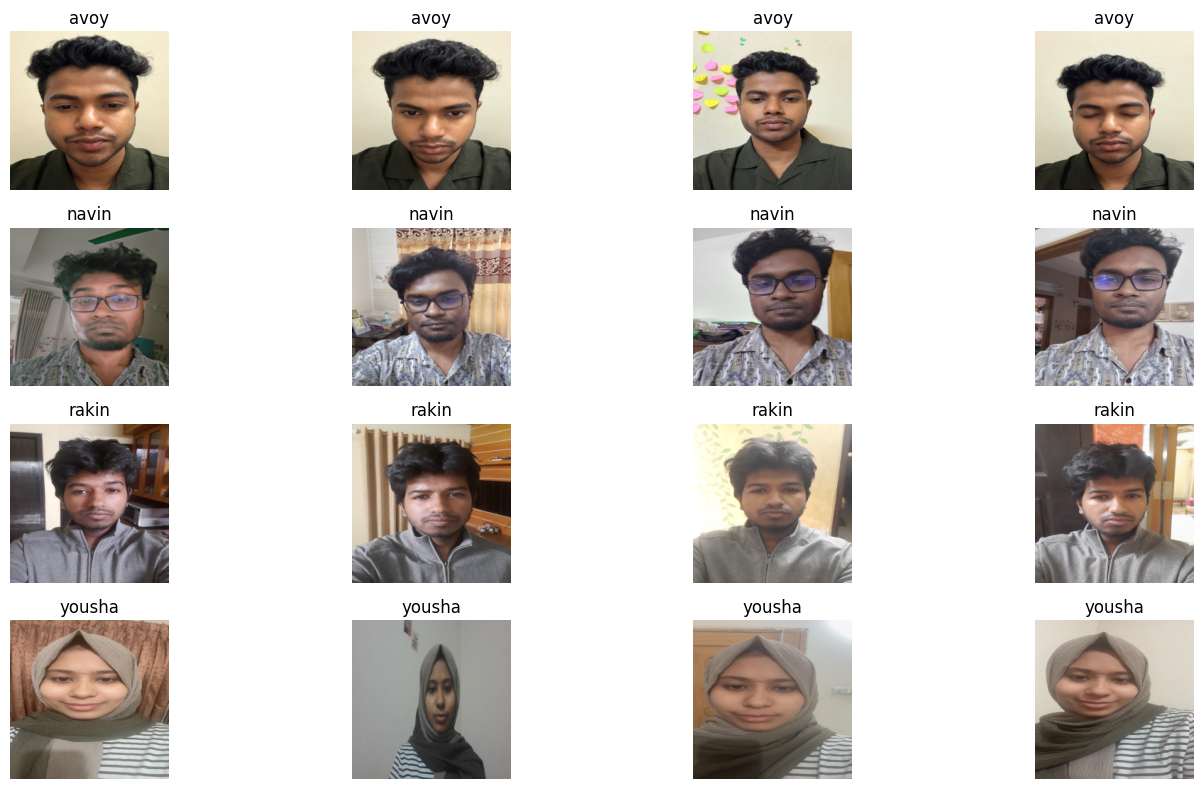

Sample images saved to output/sample_images.png


In [5]:
# Display sample images from each class
plt.figure(figsize=(15, 8))
samples_per_class = 4

for idx, class_name in enumerate(label_encoder.classes_):
    # Find indices of this class in training set
    class_indices = np.where(np.argmax(y_train, axis=1) == idx)[0]
    
    # Select random samples
    sample_indices = np.random.choice(class_indices, 
                                     min(samples_per_class, len(class_indices)), 
                                     replace=False)
    
    for i, sample_idx in enumerate(sample_indices):
        plt.subplot(num_classes, samples_per_class, idx * samples_per_class + i + 1)
        # Display as uint8 for correct matplotlib rendering
        plt.imshow(X_train[sample_idx].astype('uint8'))
        plt.title(f"{class_name}")
        plt.axis('off')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()
print("Sample images saved to output/sample_images.png")

## 6. Compute Class Weights for Imbalanced Dataset

In [6]:
# Compute class weights to handle imbalance
y_train_labels = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights_array))

print("Class weights (to handle imbalance):")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {class_weights[idx]:.3f}")

Class weights (to handle imbalance):
  avoy: 0.948
  navin: 1.375
  rakin: 1.375
  yousha: 0.671


## 7. Data Augmentation Setup

Since we have a small dataset (138 images), we'll use aggressive data augmentation to artificially expand the training data and improve generalization.

In [7]:
# Create data augmentation generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Randomly rotate images by ±20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by 20%
    height_shift_range=0.2,      # Randomly shift images vertically by 20%
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Random zoom by ±20%
    horizontal_flip=True,        # Randomly flip images horizontally
    brightness_range=[0.8, 1.2], # Random brightness adjustment
    fill_mode='nearest'          # Fill pixels outside boundaries
)

# Rescale validation data as well
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data augmentation configured successfully!")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(val_generator)}")

Data augmentation configured successfully!
Training batches per epoch: 7
Validation batches per epoch: 2


## 8. Visualize Augmented Images

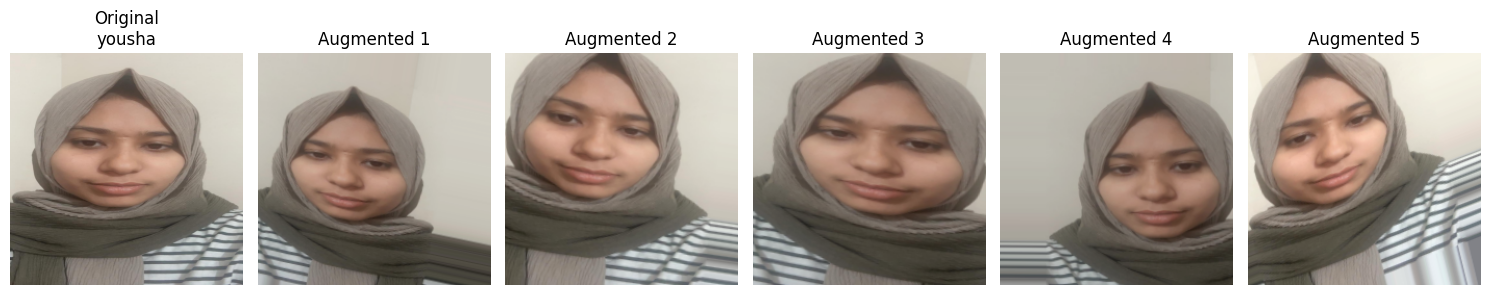

Augmentation examples saved to output/augmentation_examples.png


In [8]:
# Show augmented versions of a sample image
sample_img = X_train[0:1]  # Take first image in 0-255 range
sample_label = label_encoder.classes_[np.argmax(y_train[0])]

plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(sample_img[0].astype('uint8'))
plt.title(f'Original\n{sample_label}')
plt.axis('off')

# Generate augmented versions (these will be rescaled to 0-1 by flow)
aug_iter = train_datagen.flow(sample_img, batch_size=1)
for i in range(5):
    aug_img = next(aug_iter)[0] # This is now in [0, 1] range due to rescale
    plt.subplot(1, 6, i + 2)
    plt.imshow(aug_img)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print("Augmentation examples saved to output/augmentation_examples.png")

## 9. Build CNN Model

CNN architecture adapted from the provided template with:
- 4 Convolutional blocks with BatchNormalization and Dropout
- 3 Dense layers (512→256→128) matching the template structure
- He normal initialization for ReLU activations

In [9]:
# Create CNN model
model = keras.Sequential([
    # Input layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Convolutional Block 4
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Flatten and Dense layers (matching template structure)
    layers.Flatten(),
    
    # First dense layer
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Second dense layer
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Third dense layer
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 26,249,284 (100.13 MB)

 Trainable params: 26,246,532 (100.12 MB)

 Non-trainable params: 2,752 (10.75 KB)

## 10. Setup Training Callbacks

In [10]:
# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        filepath=f'{OUTPUT_PATH}/face_recognition_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - EarlyStopping (patience=15)")
print("  - ReduceLROnPlateau (patience=5, factor=0.5)")
print("  - ModelCheckpoint (save best model)")

Callbacks configured:
  - EarlyStopping (patience=15)
  - ReduceLROnPlateau (patience=5, factor=0.5)
  - ModelCheckpoint (save best model)


## 11. Train the Model

In [11]:
print("Starting training...\n")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,  # Handle class imbalance
    verbose=1
)

print("\nTraining completed!")

Starting training...

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3464 - loss: 1.7253
Epoch 1: val_accuracy improved from None to 0.25000, saving model to output/face_recognition_model.h5



Epoch 1: finished saving model to output/face_recognition_model.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3727 - loss: 1.6597 - val_accuracy: 0.2500 - val_loss: 5.1374 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5099 - loss: 1.1306
Epoch 2: val_accuracy did not improve from 0.25000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5545 - loss: 1.2808 - val_accuracy: 0.2500 - val_loss: 3.5348 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6176 - loss: 1.0543
Epoch 3: val_accuracy improved from 0.25000 to 0.32143, saving model to output/face_recognition_model.h5



Epoch 3: finished saving model to output/face_recognition_model.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6091 - loss: 1.1474 - val_accuracy: 0.3214 - val_loss: 2.0132 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6614 - loss: 0.9854
Epoch 4: val_accuracy improved from 0.32143 to 0.39286, saving model to output/face_recognition_model.h5



Epoch 4: finished saving model to output/face_recognition_model.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6455 - loss: 0.9834 - val_accuracy: 0.3929 - val_loss: 1.1694 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5681 - loss: 1.1289
Epoch 5: val_accuracy did not improve from 0.39286
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5727 - loss: 1.0750 - val_accuracy: 0.2500 - val_loss: 1.1846 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7341 - loss: 0.8204
Epoch 6: val_accuracy did not improve from 0.39286
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7273 - loss: 0.7971 - val_accuracy: 0.2500 - val_loss: 1.3787 - learning_rate: 1.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6295 - loss: 0.8747
Epoch 7: val_accuracy did not improve from 0.39286
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6455 - loss: 0.8527 - val_accuracy: 0.2500 - val_loss: 1.44

## 12. Plot Training History

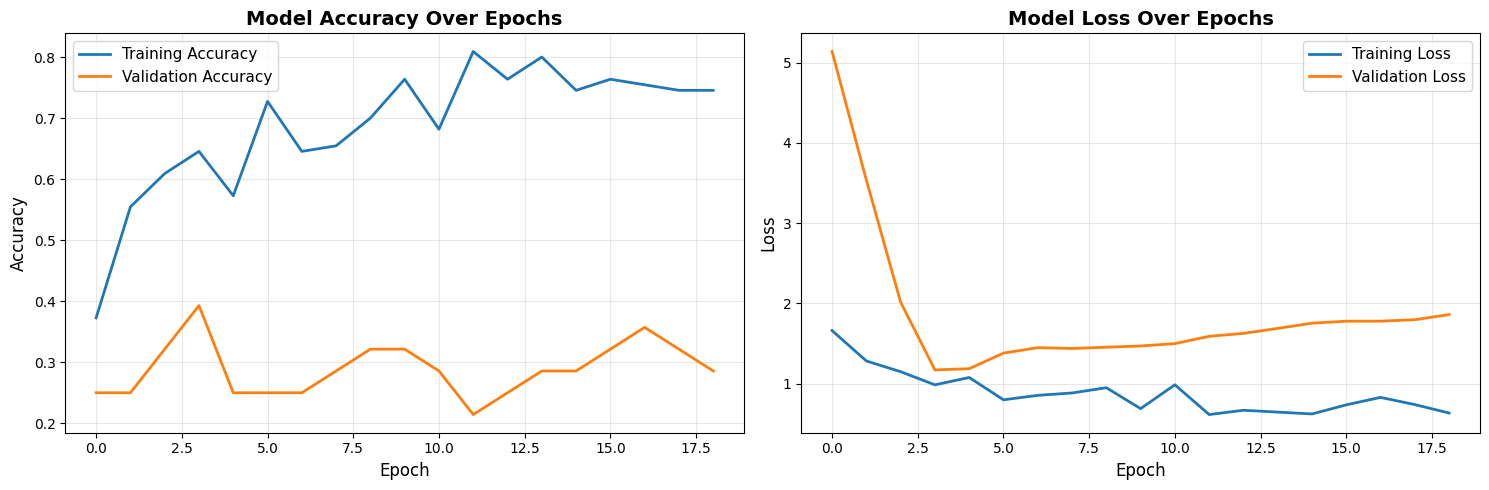

Training history plots saved to output/training_history.png


In [12]:
# Plot training and validation accuracy/loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plots saved to output/training_history.png")

## 13. Evaluate Model on Validation Set

In [ ]:
# Evaluate on validation set
# We use the generator here because validation data needs rescaling
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)

print("\n=== Final Model Performance ===")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Get predictions using the generator
y_pred = model.predict(val_generator, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

## 14. Confusion Matrix

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to output/confusion_matrix.png")

## 15. Classification Report

In [ ]:
# Generate classification report
report = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
)

print("\n=== Classification Report ===")
print(report)

# Save report to file
with open(f'{OUTPUT_PATH}/classification_report.txt', 'w') as f:
    f.write("Classification Report\n")
    f.write("=" * 50 + "\n\n")
    f.write(report)

print("Classification report saved to output/classification_report.txt")

## 16. Per-Class Accuracy Analysis

In [ ]:
# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(label_encoder.classes_, per_class_accuracy * 100, 
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, per_class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{acc*100:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPer-class accuracy:")
for class_name, acc in zip(label_encoder.classes_, per_class_accuracy):
    print(f"  {class_name}: {acc*100:.2f}%")

## 17. Sample Predictions Visualization

In [ ]:
# Show sample predictions
num_samples = min(12, len(X_val))
sample_indices = np.random.choice(len(X_val), num_samples, replace=False)

plt.figure(figsize=(16, 12))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 4, i + 1)
    # Display scaled back to uint8 for visualization
    plt.imshow(X_val[idx].astype('uint8'))
    
    true_label = label_encoder.classes_[y_true_classes[idx]]
    pred_label = label_encoder.classes_[y_pred_classes[idx]]
    confidence = y_pred[idx][y_pred_classes[idx]] * 100
    
    # Color code: green for correct, red for incorrect
    color = 'green' if true_label == pred_label else 'red'
    
    plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
              color=color, fontweight='bold', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions saved to output/sample_predictions.png")

## 18. Save Model and Label Encoder

In [ ]:
# Model is already saved by ModelCheckpoint callback
print(f"Model saved to: {OUTPUT_PATH}/face_recognition_model.h5")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"Label encoder saved to: label_encoder.pkl")

# Save model architecture summary
with open(f'{OUTPUT_PATH}/model_architecture.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"Model architecture saved to: {OUTPUT_PATH}/model_architecture.txt")

## 19. Training Summary

In [ ]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total images: {len(X)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {', '.join(label_encoder.classes_)}")

print(f"\nModel Architecture:")
print(f"  Input shape: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"  Convolutional blocks: 4")
print(f"  Dense layers: 3 (512→256→128)")
print(f"  Output classes: {num_classes}")
print(f"  Total parameters: {model.count_params():,}")

print(f"\nTraining Configuration:")
print(f"  Epochs trained: {len(history.history['loss'])}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Data augmentation: Enabled")
print(f"  Class weights: Applied")

print(f"\nFinal Performance:")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Validation Loss: {val_loss:.4f}")

print(f"\nOutput Files:")
print(f"  ✓ Model: {OUTPUT_PATH}/face_recognition_model.h5")
print(f"  ✓ Label encoder: label_encoder.pkl")
print(f"  ✓ Training history plot: {OUTPUT_PATH}/training_history.png")
print(f"  ✓ Confusion matrix: {OUTPUT_PATH}/confusion_matrix.png")
print(f"  ✓ Classification report: {OUTPUT_PATH}/classification_report.txt")
print(f"  ✓ Per-class accuracy: {OUTPUT_PATH}/per_class_accuracy.png")
print(f"  ✓ Sample predictions: {OUTPUT_PATH}/sample_predictions.png")
print(f"  ✓ Model architecture: {OUTPUT_PATH}/model_architecture.txt")

print("\n" + "="*60)
print("READY FOR WEBCAM TESTING!")
print("Run: python 'webcam_face_detector_MAIN (1).py'")
print("="*60)